In [1]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import cv2
%matplotlib widget

In [2]:
class GradientIntersect:
    def createGrid(self, Y, X):

        # create grid vectors
        grid = np.array([[y, x] for y in range(1 - Y, Y)
                         for x in range(1 - X, X)],
                        dtype='float')

        # normalize grid vectors
        grid2 = np.sqrt(np.einsum('ij,ij->i', grid, grid))
        grid2[grid2 == 0] = 1
        grid /= grid2[:, np.newaxis]

        # reshape grid for easier displacement selection
        grid = grid.reshape(Y * 2 - 1, X * 2 - 1, 2)

        return grid

    def createGradient(self, image):

        # get image size
        Y, X = image.shape

        # calculate gradients
        gy, gx = np.gradient(image)
        gx = np.reshape(gx, (X * Y, 1))
        gy = np.reshape(gy, (X * Y, 1))
        gradient = np.hstack((gy, gx))

        # normalize gradients
        gradient2 = np.sqrt(np.einsum('ij,ij->i', gradient, gradient))
        gradient2[gradient2 == 0] = 1
        gradient /= gradient2[:, np.newaxis]

        return gradient

    def locate(self, image, sigma=2, accuracy=1):

        # get image size
        Y, X = image.shape
        # get grid
        grid = self.createGrid(Y, X)

        # create empty score matrix
        scores = np.zeros((Y, X))

        # normalize image
        image = (image.astype('float') - np.min(image)) / np.max(image)

        # blur image
        blurred = gaussian_filter(image, sigma=sigma)

        # get gradient
        gradient = self.createGradient(image)

        # loop through all pixels
        for cy in range(0, Y, accuracy):
            for cx in range(0, X, accuracy):
                # select displacement
                displacement = grid[Y - cy - 1:Y * 2 - cy - 1,
                                    X - cx - 1:X * 2 - cx - 1, :]
                displacement = np.reshape(displacement, (X * Y, 2))

                # calculate score
                score = np.einsum('ij,ij->i', displacement, gradient)
                score = np.einsum('i,i->', score, score)
                scores[cy, cx] = score
        # multiply with the blurred darkness
        scores = scores * (1 - blurred)
        # if we skipped pixels, get more accurate around the best pixel
        if accuracy > 1:

            # get maximum value index
            (yval, xval) = np.unravel_index(np.argmax(scores), scores.shape)

            # prevent maximum value index from being close to 0 or max
            yval = min(max(yval, accuracy), Y - accuracy - 1)
            xval = min(max(xval, accuracy), X - accuracy - 1)

            # loop through new pixels
            for cy in range(yval - accuracy, yval + accuracy + 1):
                for cx in range(xval - accuracy, xval + accuracy + 1):

                    # select displacement
                    displacement = grid[Y - cy - 1:Y * 2 - cy - 1,
                                        X - cx - 1:X * 2 - cx - 1, :]
                    displacement = np.reshape(displacement, (X * Y, 2))

                    # calculate score
                    score = np.einsum('ij,ij->i', displacement, gradient)
                    score = np.einsum('i,i->', score, score)
                    scores[cy, cx] = score * (1 - blurred[cy, cx])

        (yval, xval) = np.unravel_index(np.argmax(scores), scores.shape)

        # return values
        return (yval, xval), scores


Text(0.5, 0, 'z label')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
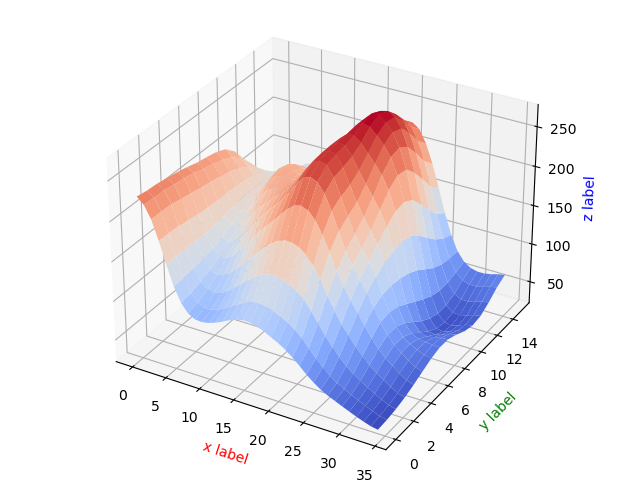

In [3]:
from mpl_toolkits.mplot3d import Axes3D
fig1=plt.figure()#建立一個繪圖物件
ax=Axes3D(fig1)#用這個繪圖物件建立一個Axes物件(有3D座標)
# FILENAME = "/aidata/anders/objects/landmarks/demo_video/2021_12_24/eyes/img_00006.jpg"
FILENAME = "../output.jpg"
gray = plt.imread(FILENAME)
gray = np.asarray(gray)
gi= GradientIntersect()
idx, scores = gi.locate(gray,  accuracy=1)
idx = np.asarray(idx)
idx[0] = idx[0] - 1
idx[1] = idx[1] - 2
#gray = np.where(scores >  np.max(scores)//2, gray, 255)
#gray = gray.astype(np.uint8)
#cv2.imwrite("output.jpg", gray)

Y, X = gray.shape

X, Y = np.meshgrid(list(range(X)),list(range(Y)))

ax.plot_surface(X, Y, scores, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
ax.set_xlabel('x label', color='r')
ax.set_ylabel('y label', color='g')
ax.set_zlabel('z label', color='b')#給三個座標軸註明


In [333]:
from scipy.optimize import curve_fit
def double_gaussian( x, c1, mu1, sigma1, c2, mu2, sigma2):
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ) 
    return res

y, x = idx
Y, X = gray.shape
cut_x_data = np.asarray([scores[y, i] for i in range(X)])
cut_y_data = np.asarray([scores[i, x] for i in range(Y)])

[6512.12600078 -376.7960485   205.78051616  130.28146642   32.18476815
    9.65070717]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
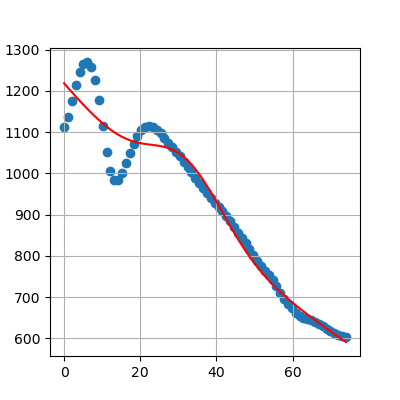

In [334]:
x_data = np.linspace(0, X, X) 
fig1=plt.figure(figsize=(4, 4))
popt_x_cut, pcov_x_cut = curve_fit(double_gaussian, x_data, cut_x_data)
print(popt_x_cut)
fit_x_cut = double_gaussian(x_data, *popt_x_cut)
plt.scatter(x_data, cut_x_data)
plt.plot(x_data, fit_x_cut, color = "red")
plt.grid()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
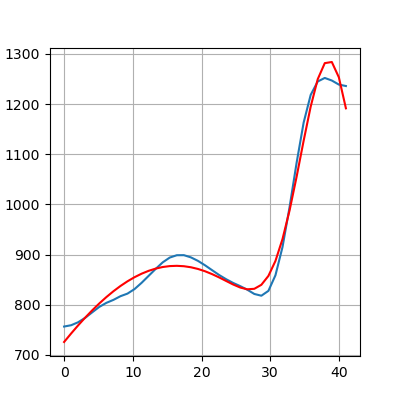

In [336]:
from pprint import pprint
def gaussian(x, s, mu, scaling):
    return (scaling * np.exp(-(x-mu)**2) / (2. * s**2))
x_data = np.linspace(0, Y, Y) 
diffs =  np.diff(cut_y_data)
left_pos = diffs[:y] > 0
right_pos = diffs[y:] > 0

left_idxs = np.where(left_pos)[0]
right_idxs = np.where(right_pos)[0]

min_idx = np.min(left_idxs)
max_idx = np.min(right_idxs) + y

popt_y_cut, pcov_y_cut = curve_fit(double_gaussian, x_data, cut_y_data)

fit_y_cut = double_gaussian(x_data, *popt_y_cut)
fig1=plt.figure(figsize=(4, 4))
plt.plot(x_data, cut_y_data)
plt.plot(x_data, fit_y_cut, color = "red")
plt.grid()
plt.show()